## Convolutional Neural Network that predicts whether RNAP will bind to an arbitrary sequence

(Trained on the Ecoli genome)

In [1]:
import pandas as pd
import numpy as np

input_data_raw =  pd.read_csv('rnap_scanned_over_ecoli_genome.csv')
sequences = input_data_raw['seq'].tolist()

## Raw Data
The seq column below contains positive training examples. Sequences that RNAP will bind to. 

In [2]:
input_data_raw.head()

,val,seq,left,right,ori,contig
0,23.9083,CTATTACCTGCCCACGGTAAAGGCGTTCTGGTTGCCCTACG,3695629,3695669,+,MG1655.fa
1,23.5831,TTTCTGCCCGCGGCCTGGCAATTGATACCGCCTTGCCATCG,1109059,1109099,+,MG1655.fa
2,23.4205,TTTTTACACGCCTTGCGTAAAGCGGCACGGCGCGGGGTGCG,822216,822256,-,MG1655.fa
3,23.4098,TTGCTGCCTGGCCGATGGTCTATGCCGCTGCGTTCTCCGGC,772478,772518,+,MG1655.fa
4,23.3640,CTTTTACACGCAAAATGCCGTCACGTTCACGGGTCTGGGCT,2748531,2748571,+,MG1655.fa


## Set up lists that will contain positive sequences and positive test sequences

In [3]:
pos = []
test_pos = []

num_sample = 9000
test_size = 1000

for index in range(len(sequences[0:num_sample])):
    pos.append(list(sequences[index]))
    
for test_index in range(len(sequences[num_sample:num_sample+test_size])):
    test_pos.append(list(sequences[index]))    

pos = np.array(pos)
test_pos = np.array(test_pos)

seq_length = len(pos[0])

... and negative training and test sequences 

In [4]:
neg = np.array([np.random.choice(['A', 'C', 'G', 'T'], num_sample, p=np.array([1,1,1,1])/4.0)
                for i in range(seq_length)]).transpose()

test_neg = np.array([np.random.choice(['A', 'C', 'G', 'T'], test_size, p=np.array([1,1,1,1])/4.0)
                for i in range(seq_length)]).transpose()

[''.join(x) for x in neg[1:10,:]]

['AAGGTAAGAACGCGCCGTCTTAAAGAGTATGAGCCACGAGG',
 'GGCGGGCGACGTCGGGAAAAAGGCTAAAGTAATGTCAGTTT',
 'AATTCTGGTATCGGCAAAGAAGTGATATCCATACGCCAATA',
 'CATAATCAAAAGGTGCAACGTCGCCCTAGACCGACATAACT',
 'GGCCATCGGGGGCACTTCGAAACGCAGGTGATCGGCTGAGA',
 'ATCTAGTCAATCAAACGGTGCCTCTTACGAGAACTACCCTG',
 'ACACCGATTGCGTACCTCTGAAGGCCGATTTCATTTTGGAG',
 'CCCTGAGGGACAAGATCGCGATTACTCGCTCAGGGATTTGG',
 'TCCGGGTGCCCACAGCAGGCCGAGACCATGGCAGGGGAGAA']

In [5]:
np.shape(pos)

(9000, 41)

## Change training examples to one-hot encoded tensors

### and put labels in tensors called 'y' and 'y_test'

In [6]:
pos_tensor = np.zeros(list(pos.shape) + [4])
neg_tensor = np.zeros(list(neg.shape) + [4])

test_pos_tensor = np.zeros(list(test_pos.shape) + [4])
test_neg_tensor = np.zeros(list(test_neg.shape) + [4])

base_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

#naive one-hot encoding
for row in range(num_sample):
    for col in range(seq_length):
        pos_tensor[row,col,base_dict[pos[row,col]]] = 1
        neg_tensor[row,col,base_dict[neg[row,col]]] = 1
        if(row<test_size):
            test_pos_tensor[row,col,base_dict[test_pos[row,col]]] = 1
            test_neg_tensor[row,col,base_dict[test_neg[row,col]]] = 1        

print('Positive sample matrix shape: {}'.format(pos.shape))
# this should be a 3D tensor with shape: (samples, steps, input_dim)
print('Positive sample tensor shape: {}'.format(pos_tensor.shape))

X = np.vstack((pos_tensor, neg_tensor))
y = np.concatenate((np.ones(num_sample), np.zeros(num_sample)))

y_test = np.concatenate((np.ones(test_size), np.zeros(test_size)))

print('Training set shape: {}'.format(X.shape))
print('Training set label shape: {}'.format(y.shape))
print('\nOne-hot encoding looks like:\n {}'.format(X[0,0:10,:]))

Positive sample matrix shape: (9000, 41)
Positive sample tensor shape: (9000, 41, 4)
Training set shape: (18000, 41, 4)
Training set label shape: (18000,)

One-hot encoding looks like:
 [[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


In [7]:
X.shape

(18000, 41, 4)

In [8]:
y.shape

(18000,)

## Define Neural Network using Keras

In [9]:
#here comes the deep learning part
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Dropout
from keras.activations import relu
from keras.layers.pooling import MaxPooling1D
from keras.optimizers import SGD, Adam

model = Sequential()
model.add(Conv1D(1, 41, padding='same', input_shape=(seq_length, 4), activation='relu'))


#sanity check for dimensions
print('Shape of the output of first layer: {}'.format(model.predict_on_batch(pos_tensor[0:1,:,:]).shape))

Using TensorFlow backend.


Shape of the output of first layer: (1, 41, 1)


In [10]:
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(10, 20, padding='same', input_shape=(seq_length, 4), activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])
model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

history = model.fit(X, y, validation_split=0.3, epochs=20)  # starts training



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 41, 1)             165       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 1)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 10)            210       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 10)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1020      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
__________

In [11]:
# I want to see if I can train the weights of the first conv layer to recover the 
# RNAP position weight matrix. I decided on using 1 filter with kernel size equal to 
# the sequences length (41). I will have to play around it with it more, right now the predictions
# for the PWM don't look better than random ,on average, although sometimes I can get more than 60%
# accuracy, though that might just be chance.

convlayer = model.layers[0]
weights = convlayer.get_weights()[0].squeeze()
print('Convolution parameter shape: {}'.format(weights.shape))

num2seq = ['A','C','G','T']

test_pred = ''.join([num2seq[np.argmax(weights[i,:])] for i in range(weights.shape[0])])


# characters stacked at the top of the RNAP PWM logo
top_logo_chars = ['C','T','A','C','T','A','C','A','C','G',
                  'C','C','C','C','A','T','A','T','T','G',
                  'A','G','C','G','A','T','C','C','C','G',
                  'G','G','T','T','C','C','C','C','C','C',
                  'G']

test_pred_array = np.array(list(test_pred))
test_pred_array

total = 0
for base_index in range(len(np.array(top_logo_chars))):
    if(top_logo_chars[base_index]==test_pred_array[base_index]):
        total+=1
print("PWM top base prediction: ",total,"out of 41")  

Convolution parameter shape: (41, 4)
PWM top base prediction:  12 out of 41


## Plot Loss functions and model Accuracy

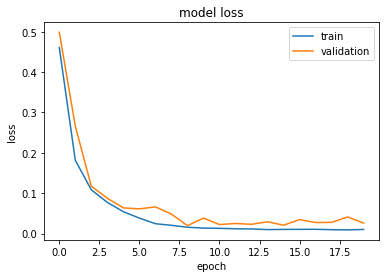

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

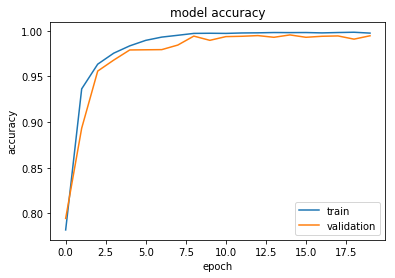

In [13]:
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

## Make predictions

In [14]:
y_pred_pos = model.predict(test_pos_tensor)
y_pred_neg = model.predict(test_neg_tensor)

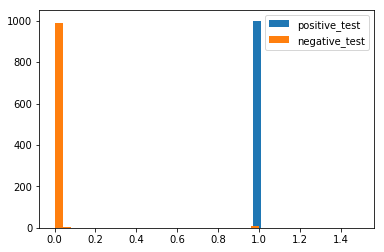

In [15]:
plt.hist(y_pred_pos,bins=25,label='positive_test')
plt.hist(y_pred_neg,bins=25,label='negative_test')
plt.legend()
plt.show()

In [16]:
wrong_neg_predictions = 0
for neg_index in range(len(y_test[1000:2000].reshape(1000,1))):
    if(abs(y_pred_neg[neg_index]-y_test[neg_index+1000])>0.1):
        #print(neg_index,y_pred_neg[neg_index])
        wrong_neg_predictions+=1

wrong_pos_predictions = 0
for pos_index in range(len(y_test[0:1000].reshape(1000,1))):
    if(abs(y_pred_pos[pos_index]-y_test[pos_index])>0.1):
        #print(pos_index,y_pred_pos[pos_index])
        wrong_pos_predictions+=1


In [17]:
print("wrong predictions on negative test:",wrong_neg_predictions, "out of ",len(y_pred_pos)," predictions")
print("wrong predictions on positive test:",wrong_pos_predictions," out of ",len(y_pred_neg)," predictions")

wrong predictions on negative test: 10 out of  1000  predictions
wrong predictions on positive test: 0  out of  1000  predictions
